<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/tpu_fastai_demo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [3]:
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4994  100  4994    0     0  26423      0 --:--:-- --:--:-- --:--:-- 26423
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
     |████████████████████████████████| 61kB 2.6MB/s 
Uninstalling torch-1.5.1+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     


In [4]:
!pip install fastai2 --upgrade > /dev/null

In [5]:
!pip install git+https://github.com/butchland/fastai_xla_extensions > /dev/null

  Running command git clone -q https://github.com/butchland/fastai_xla_extensions /tmp/pip-req-build-a6dqazuq


In [2]:
import torch
import torch.cuda

In [3]:
XLA_AVAILABLE = True
try:
    import torch_xla.core.xla_model as xm
except ImportError as e:
    XLA_AVAILABLE = False
    import warnings
    warnings.warn('fastai_xla_extensions requires Pytorch-XLA, will revert to default',
                  RuntimeWarning)

In [4]:
from fastcore.foundation import defaults

In [5]:
import fastai2.torch_core

In [6]:
if XLA_AVAILABLE:
    defaults.tpu_available = True
    defaults.tpu_device = xm.xla_device()

In [7]:
if XLA_AVAILABLE:
    def default_device(use_cuda=-1):
        "Return TPU"
        return defaults.tpu_device
    def to_device(b, device=None):
        "Recursively put `b` on `device`."
        if device is None: device=default_device()
        # print(f'setting device to {device}')
        def _inner(o): return o.to(device, non_blocking=True) if isinstance(o,Tensor) else o.to_device(device) if hasattr(o, "to_device") else o
        return apply(_inner, b)

    fastai2.torch_core.default_device = default_device
    fastai2.torch_core.to_device = to_device
    


In [8]:
from fastai2.vision.all import *

In [9]:
orig_create_opt = Learner.create_opt
@patch_to(Learner)
def create_opt(self):
    orig_opt_func = self.opt_func
    self.opt_func = XLAOptFuncWrapper(orig_opt_func)
    orig_create_opt(self)


In [10]:
from fastai_xla_extensions.core import *

In [11]:
path = untar_data(URLs.PETS)/'images'
Path.BASE_PATH = path
path.ls()

(#7393) [Path('american_pit_bull_terrier_194.jpg'),Path('Maine_Coon_155.jpg'),Path('pomeranian_185.jpg'),Path('pomeranian_66.jpg'),Path('chihuahua_88.jpg'),Path('great_pyrenees_177.jpg'),Path('english_setter_129.jpg'),Path('samoyed_53.jpg'),Path('american_bulldog_8.jpg'),Path('Ragdoll_188.jpg')...]

In [12]:
def is_cat(item):
  return 'cat' if item.name[0].isupper() else 'dog'

In [13]:
L(zip(path.ls()[:10], map(is_cat,path.ls()[:10])))

(#10) [(Path('american_pit_bull_terrier_194.jpg'), 'dog'),(Path('Maine_Coon_155.jpg'), 'cat'),(Path('pomeranian_185.jpg'), 'dog'),(Path('pomeranian_66.jpg'), 'dog'),(Path('chihuahua_88.jpg'), 'dog'),(Path('great_pyrenees_177.jpg'), 'dog'),(Path('english_setter_129.jpg'), 'dog'),(Path('samoyed_53.jpg'), 'dog'),(Path('american_bulldog_8.jpg'), 'dog'),(Path('Ragdoll_188.jpg'), 'cat')]

In [14]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    get_y=is_cat,
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(340),
    batch_tfms=aug_transforms(size=224,min_scale=0.75)
)

In [15]:
datablock.summary(path)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: is_cat -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/chihuahua_178.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=300x225
  Pipeline: is_cat -> Categorize
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/chihuahua_178.jpg
    applying is_cat gives
      dog
    applying Categorize gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=300x225, TensorCategory(1))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=300x225, TensorCategory(

In [23]:
datablock2 = datablock.new(item_tfms=Resize(224), batch_tfms=[])

In [24]:
dls = datablock2.dataloaders(path)


In [25]:
dls.device

device(type='xla', index=1)

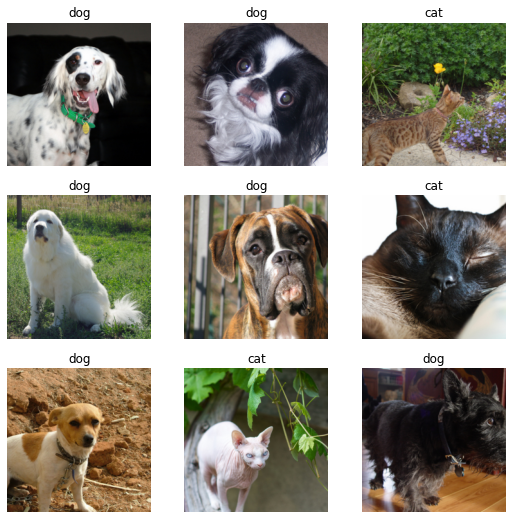

In [26]:
dls.show_batch()

In [27]:
learner = cnn_learner(dls,resnet34,metrics=accuracy)

In [28]:
L(learner.model.parameters())[0].device

device(type='xla', index=1)

In [29]:
dls.device

device(type='xla', index=1)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0005754399462603033)

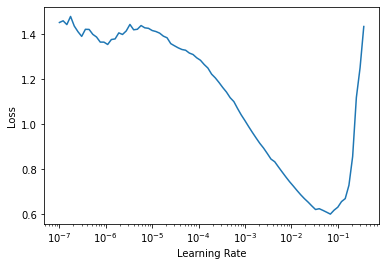

In [30]:
learner.lr_find()

In [21]:
learner.fine_tune(1, base_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.135727,0.017943,0.991881,09:11


epoch,train_loss,valid_loss,accuracy,time
0,0.118513,0.035939,0.985792,08:51


In [ ]:
learner.save('stage1')

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

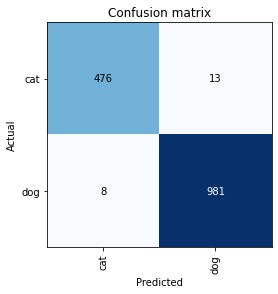

In [ ]:
interp.plot_confusion_matrix()

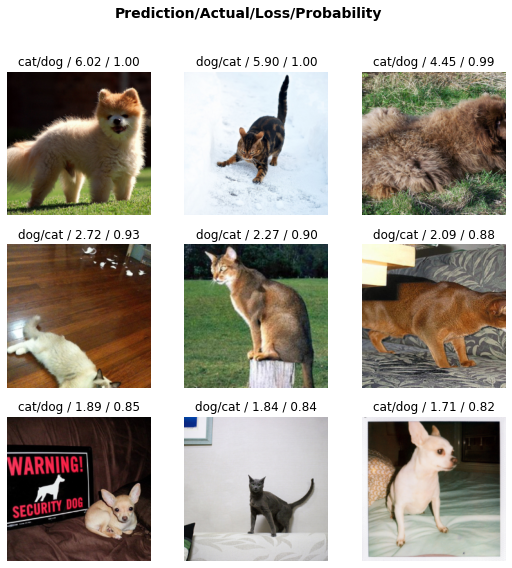

In [ ]:
interp.plot_top_losses(9)

In [ ]:
datablock2 = datablock.new(batch_tfms=[], item_tfms=Resize(224))

In [ ]:
dls2 = datablock2.dataloaders(path,device=tpu)

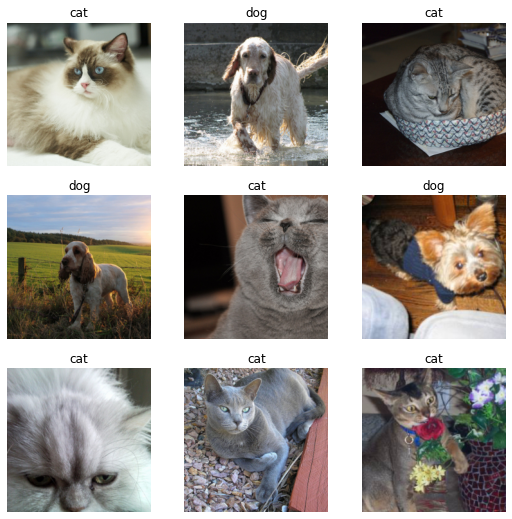

In [ ]:
dls2.show_batch()

In [ ]:
learner2 = cnn_learner(dls2,resnet34,metrics=accuracy, opt_func=XLAOptFuncWrapper(Adam))

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0003311311302240938)

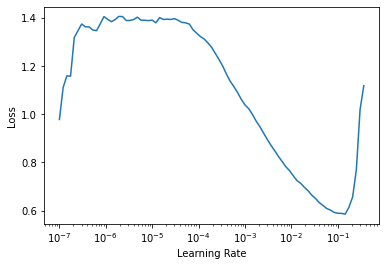

In [ ]:
learner2.lr_find()

In [ ]:
datablock2.summary(path)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: is_cat -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bengal_171.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=300x225
  Pipeline: is_cat -> Categorize
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bengal_171.jpg
    applying is_cat gives
      cat
    applying Categorize gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=300x225, TensorCategory(0))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=300x225, TensorCategory(0))
    applying Resize gives
      (PILImage mode=RGB size=224

In [ ]:
learner2.fine_tune(1, base_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.102799,0.069023,0.987821,01:52


epoch,train_loss,valid_loss,accuracy,time
0,0.102306,0.025617,0.991881,01:50


In [ ]:
interp2 = ClassificationInterpretation.from_learner(learner2)

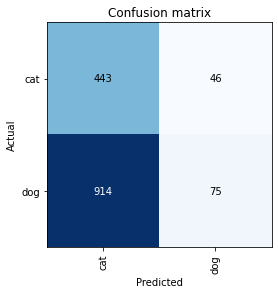

In [ ]:
interp2.plot_confusion_matrix()

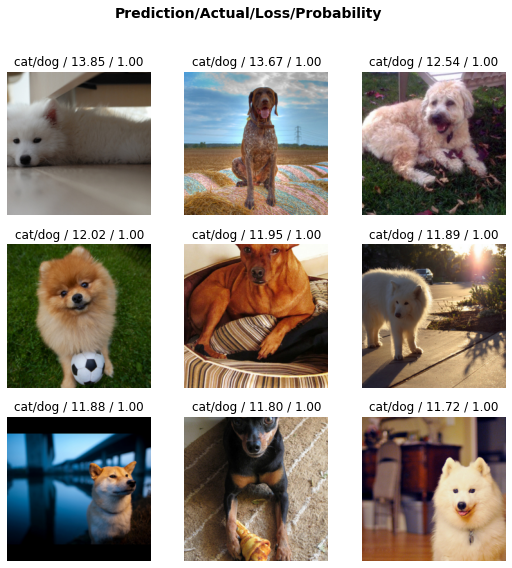

In [ ]:
interp2.plot_top_losses(9)